In [61]:
# TODO compare to using variants annotated in other ways e.g. deepsea or sat mutgen?

In [1]:
import tailer

In [15]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import os
import pandas as pd
import scipy.stats

DIR="/storage/mgymrek/agent-bind/singletons"

factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]

factordata = {}
factorpercs = {}

percs = [99]
rank_perc = [995]
raw_perc = [999]

for f in factors:
    fdata = pd.read_csv(os.path.join(DIR, f, "factor_singletons.tab"), sep="\t", skiprows=1,
                   names=["chrom","pos","ref","alt","freq","raw.score","snr.score","rank","core"])
    fdata["freq"] = fdata["freq"].apply(lambda x: min([x, 1-x])) # Make sure we have MAF
    fdata = fdata[fdata["freq"]>0] # Remove if it wasn't seen in anybody. why are those present?
    fdata["sing"] = (fdata["freq"]<=0.0002)
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    
    num_data = sum(1 for line in open(os.path.join(DIR, f, "raw_vals.txt")))
    fpercs = []
    for perc in raw_perc:
        linenum = num_data-int(num_data*(perc/1000.0))
        fpercs.append(float(tailer.tail(open(os.path.join(DIR, f, "raw_vals.txt")), linenum)[0].strip()))
    print(fpercs)
    factorpercs[f] = fpercs

# Get combined data
factordata["ALL"] = pd.concat(factordata.values())

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[0.0006603081474777991]
[0.002192110287785126]
[0.00046431278208011045]
[0.0005466513326916889]
[0.0005711687693293194]
[0.0011963392190008915]
[0.001181633336951489]
[0.0006844558351062346]
[0.0037465837508804944]
[0.0015370504801083817]
[0.0016797188370639426]
[0.0013099913590755713]
[0.0013075498988154854]
[0.0022002374392553897]
[0.0009028137602474229]
[0.0019534079224949596]
[0.000830777902622426]
[0.0006340585222772144]
[0.0007027816897613205]
[0.0007781603268518789]
[0.0014792670849173295]
[0.0006674724232951651]
[0.0008895795722373145]
[0.0006786819127111016]
[0.0012615880919354672]
[0.0006851187980208284]
[0.0008450233372287175]
[0.0009171491874325824]
[0.0007919383912021252]
[0.004124460332652624]
[0.0020187646632655876]
[0.0008871746449292464]
[0.0007395706895214869]
[0.0013852945334138014]
[0.0008612901170969092]
[0.0007792408653646138]
[0.0009331259220599769]
[0.0009071097794921129]


In [20]:
cols = ["factor","sing.all","sing.core","n.all","n.core","pval.core"]
for i in range(len(percs)):
    cols.extend(["sing.raw.%s"%percs[i], "sing.raw.%s.err"%percs[i], "pval.raw.%s"%percs[i],
                 "sing.snr.%s"%percs[i], "sing.snr.%s.err"%percs[i], "pval.snr.%s"%percs[i],
                 "sing.rank.%s"%percs[i], "sing.rank.%s.err"%percs[i], "pval.rank.%s"%percs[i],
                 "num.%s"%percs[i]])
data = []

for f in ["ALL"]+factors:
    fd = factordata[f]
#    print("%s - all:%.2f, core: %.2f"%(f, np.mean(fd["sing"]), np.mean(fd[fd["core"]>0]["sing"])))
    p_all = np.mean(fd["sing"])
    p_core = np.mean(fd[fd["core"]>0]["sing"])
    n_all = fd.shape[0]
    n_core = fd[fd["core"]>0].shape[0]
    d = [f, p_all, p_core, n_all, n_core]
    raw_score_perc = factorpercs.get(f, [0.0001]) # this is made up for "ALL" doesn't make sense
    snr_score_perc = np.percentile(fd["snr.score"], percs)
    #rank_perc = np.percentile(fd["rank"], percs)

    # Get pval for core
    n_not_core = n_all-n_core
    p_not_core = (p_all*n_all-p_core*n_core)/(n_not_core)
    se_core = np.sqrt(p_all*(1-p_all)*(1.0/n_core+1.0/n_not_core))
    pval_core = 1-scipy.stats.norm.cdf((p_core-p_not_core)/se_core)
    d.append(pval_core)
    
    for i in range(len(percs)):
        r = (fd[fd["raw.score"]>=raw_score_perc[i]]["sing"])
        s = (fd[fd["snr.score"]>=snr_score_perc[i]]["sing"])
        rk = (fd[fd["rank"]>=rank_perc[i]]["sing"])
        p_r = np.mean(r)
        p_s = np.mean(s)
        p_rk = np.mean(rk)
        err_r = np.sqrt(p_r*(1-p_r)/len(r))
        err_s = np.sqrt(p_s*(1-p_s)/len(s))
        err_rk = np.sqrt(p_rk*(1-p_rk)/len(rk))
        n_r = len(r)
        n_s = len(s)
        n_rk = len(rk)
        n_not_r = n_all-n_r
        n_not_s = n_all-n_s
        n_not_rk = n_all-n_rk
        p_not_r = (p_all*n_all-np.sum(r))*1.0/n_not_r
        p_not_s = (p_all*n_all-np.sum(s))*1.0/n_not_s
        p_not_rk = (p_all*n_all-np.sum(rk))*1.0/n_not_rk
        # Compute pvals
        se_r = np.sqrt(p_all*(1-p_all)*(1.0/n_r+1.0/n_not_r))
        se_s = np.sqrt(p_all*(1-p_all)*(1.0/n_s+1.0/n_not_s))
        se_rk = np.sqrt(p_all*(1-p_all)*(1.0/n_rk+1.0/n_not_rk))
        pval_r = 1-scipy.stats.norm.cdf((p_r-p_not_r)/se_r)
        pval_s = 1-scipy.stats.norm.cdf((p_s-p_not_s)/se_s)
        pval_rk = 1-scipy.stats.norm.cdf((p_rk-p_not_rk)/se_rk)
        # Add data
        d.extend([p_r, err_r, pval_r,
                  p_s, err_s, pval_s,
                  p_rk, err_rk, pval_rk, len(s)])
    data.append(d)

results = pd.DataFrame(data, columns=cols)
results["sing.all.err"] = results.apply(lambda x: np.sqrt(x["sing.all"]*(1-x["sing.all"])/x["n.all"]), 1)
results["sing.core.err"] = results.apply(lambda x: np.sqrt(x["sing.core"]*(1-x["sing.core"])/x["n.core"]), 1)
allres = results[results["factor"]=="ALL"].copy()
results= results[results["factor"]!= "ALL"]

In [21]:
# Overall p-value
allres.transpose()

,0
factor,ALL
sing.all,0.453289
sing.core,0.459535
n.all,7207839
n.core,145162
pval.core,6.8444e-07
sing.raw.99,0.456439
sing.raw.99.err,0.00107793
pval.raw.99,0.00149659
sing.snr.99,0.463616


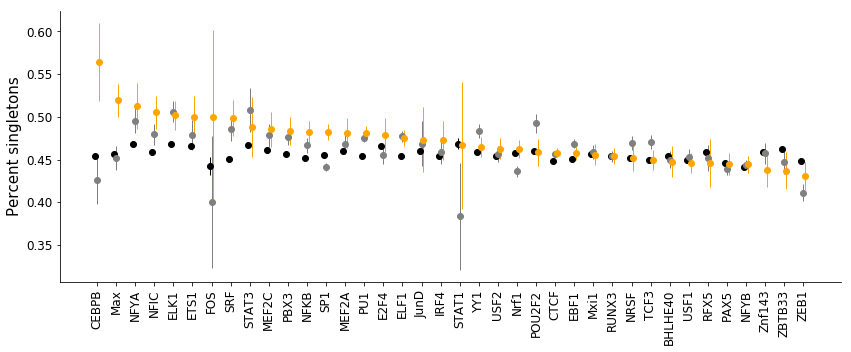

In [25]:
results = results.sort_values("sing.rank.99", ascending=False)
xvals = np.array(range(results.shape[0]))

w = 0.1
fig = plt.figure()
fig.set_size_inches((14, 5))
ax = fig.add_subplot(111)
ax.errorbar(xvals, results["sing.all"], label="All", yerr=results["sing.all.err"], marker="o", linewidth=0, elinewidth=1, color="black")
ax.errorbar(xvals+w, results["sing.core"], label="core", yerr=results["sing.core.err"], marker="o", linewidth=0, elinewidth=1, color="gray")
labl = False
for i in range(len(percs)):
    x = percs[i]
    if not labl:
        lab1 = "SNR"
        lab2 = "Raw"
    else:
        lab1 = ""
        lab2 = ""
#    ax.errorbar(xvals+w*(2+i), results["sing.snr.%s"%x], label=lab1, yerr=results["sing.snr.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="red")
#    ax.errorbar(xvals+w*(2+i), results["sing.raw.%s"%x], label=lab2, yerr=results["sing.raw.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="blue")
    ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab2, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="orange")
    labl = True
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals+w)
ax.set_xticklabels(results["factor"], rotation=90, size=12);
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12)
#ax.legend(loc="upper left")
ax.set_ylabel("Percent singletons", size=15);

In [66]:
# Look at specific snps
fd = factordata["ALL"]
fd["chrom"] = fd["chrom"].apply(str)
gwas = pd.read_csv("/storage/mgymrek/gtex/gwas/summarystats/ucsc_gwas_catalog_072419_v2.tab", sep="\t")
gwas["chrom"] = gwas["chrom"].apply(lambda x: x[3:])
gwas["pos"] = gwas["start"]
gwd = pd.merge(fd, gwas, on=["chrom","pos"])

In [67]:
allfd = fd.groupby(["chrom","pos"]).agg({"rank": max})
allgwd = gwd.groupby(["chrom","pos"]).agg({"rank": max})

In [68]:
# How many snps overlap with gwas catalog?
nums = []
overlaps = []
ranks = list(np.arange(0, 1000, 25))+[999]

for rank in ranks:
    nums.append(allfd[allfd["rank"]>=rank].shape[0])
    overlaps.append(allgwd[allgwd["rank"]>=rank].shape[0])

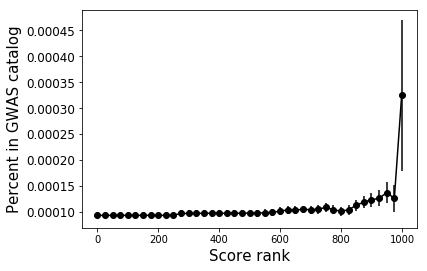

In [69]:
percs = [overlaps[i]*1.0/nums[i] for i in range(len(ranks))]
errs = [np.sqrt(percs[i]*(1-percs[i])/nums[i]) for i in range(len(ranks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(ranks, percs, marker="o", yerr=errs, color="black")
ax.set_xlabel("Score rank", size=15)
ax.set_ylabel("Percent in GWAS catalog", size=15)
ax.set_yticklabels(["%.5f"%item for item in ax.get_yticks()], size=12);